# Q3- MohammadReza Zarei 401201313

# All the Questions asked are answered at the end of the Jupyter Notebook

##  Reading the data

In [3]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
pass

# Reading train file data
Q3_train = pd.read_csv('Q3_train.csv')
y = Q3_train.to_numpy()[:,0]
x = Q3_train.to_numpy()[:,1:]

# Reading test file data
Q3_test  = pd.read_csv('Q3_test.csv')
y_test   = Q3_test.to_numpy()[:,0]
x_test   = Q3_test.to_numpy()[:,1:]

print('Train Matrix:\t{}'.format(x.shape))
print('Train Labels:\t{}'.format(y.shape))
print('Test Matrix:\t{}'.format(x_test.shape))
print('Test Labesl:\t{}'.format(y_test.shape))

Train Matrix:	(27455, 784)
Train Labels:	(27455,)
Test Matrix:	(7172, 784)
Test Labesl:	(7172,)


## A. Plotting 9 random samples

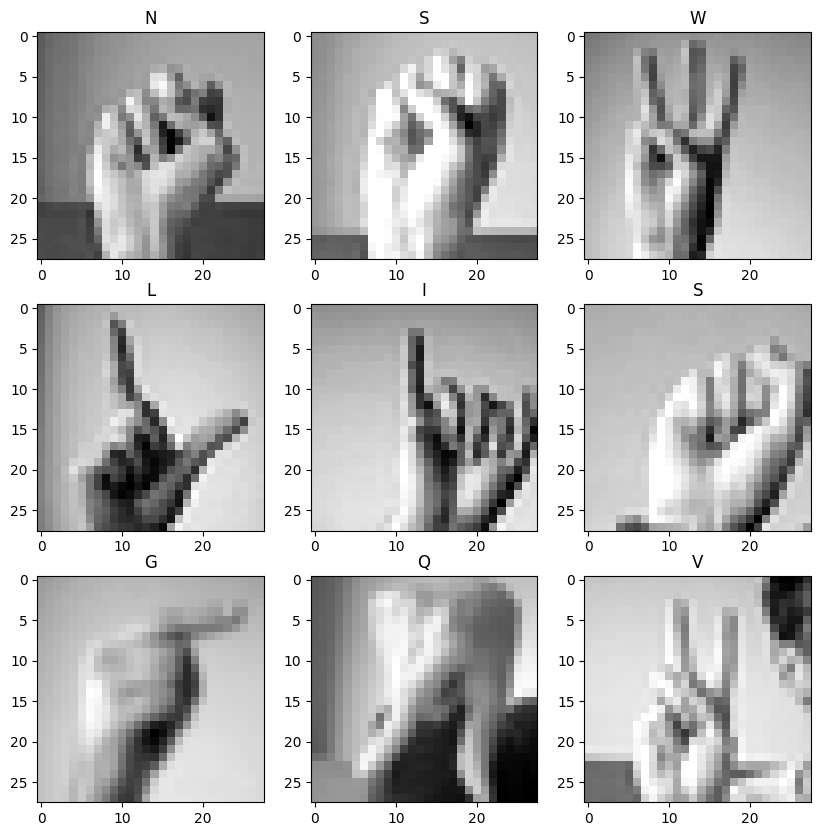

In [4]:
import matplotlib.pyplot as plt
import random
ref = dict()
for i in range(25):
    ref[i] = chr(i+65)

fig, ax = plt.subplots(3,3,figsize=(10,10))


for i in range(3):
    for j in range(3):
        c=random.randint(0, len(x))
        ax[i,j].imshow(np.reshape(x[c+j],(28,28)),cmap='gray')
        ax[i,j].set_title(ref[y[c+j]])

# Training MLP

## B. Spliting and one-hotting

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting train-valid datasets
ratio = 0.2
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=ratio, shuffle=True, random_state=0)

# Making one-hot labels
n_classes = 25
with tf.Session() as sess:
    y_train_hot = sess.run(tf.one_hot(y_train, n_classes))
    y_valid_hot = sess.run(tf.one_hot(y_valid, n_classes))
    y_test_hot  = sess.run(tf.one_hot(y_test , n_classes))

# normalization
scaler  = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test  = scaler.transform(x_test)

print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_train:\t{}'.format(x_valid.shape))
print('y_valid:\t{}'.format(y_valid.shape))

x_train:	(21964, 784)
y_train:	(21964,)
x_train:	(5491, 784)
y_valid:	(5491,)


## MLP

## B. define Functions

In [12]:
from tensorboard import program
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def linear(x_in, w, b):
    out = tf.matmul(x_in, w) + b
    return out

def run_tensorboard(log_dir):
    from tensorboard import program
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', log_dir])
    url = tb.launch()
    print(f"Tensorboard active on {url}")
    return

def show_test_results(net, x_test, y_test, cm=True):
    y_pred = net.predict(x_test)
    
    print (f'correct predictions:\t{np.sum(y_pred==y_test)} out of {len(y_test)}')
    print (f'test data accuracy:\t{accuracy_score(y_test, y_pred)}\n')
    
    if cm == True:
        cm = confusion_matrix(y_test, y_pred)
        cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        if cm_norm.shape[0] == 24:
            class_names = dict()
            for k,v in ref.items():
                if v != 'J' and v != 'Z':
                    class_names[k] = v
        else:
            class_names = ref

        con_mat_df = pd.DataFrame(cm_norm,index = class_names.values(), columns = class_names.values())
        figure = plt.figure(figsize=(15, 15))
        sns.heatmap(con_mat_df, annot=True,cmap="YlGnBu")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Test data confusion matrix')
        plt.show()
    return y_pred

## B. Class Definition

In [15]:
class MLP:
    def __init__(self, layers, dropout=0, bn = False,
                 activation = tf.nn.relu, optimizer=tf.train.AdamOptimizer,
                 lr=0.001, w_std=0.01):

        
        self.inp = layers[0]
        self.out = layers[-1]
        
        self.layers = layers
        self.depth  = len(layers) # or L-1; not so much differnce
        
        self.weights = dict()
        self.biases  = dict()
        
        self.drop_rate  = dropout # for forward pass
        self.bn = bn
        self.activation = activation
        
        with tf.variable_scope('I/O'):
            self.x_in  = tf.placeholder (dtype=tf.float32, shape=(None,self.inp),name='input')
            self.y_out = tf.placeholder (dtype=tf.float32, shape=(None,self.out),name='output')
            
        with tf.variable_scope('Dropout'):
            self.dout = tf.placeholder (dtype=tf.float32, shape=(), name='dropout')
        
        with tf.variable_scope('bn'):
            self.bnorm = tf.placeholder (dtype=tf.bool, shape=(), name = 'batch_normalization')
        
        self.graph = dict()
        self.graph[0] = self.x_in
        for i in range(1, self.depth):
            
            with tf.variable_scope(f'Layer-{i}-{i+1}'):
                self.weights[i] = tf.get_variable (
                    name = f'W_{i}',dtype = tf.float32,
                    shape = (self.layers[i-1],self.layers[i]),
                    initializer = tf.truncated_normal_initializer(stddev=w_std)
                )
                tf.summary.histogram(f'W_{i}', self.weights[i])

                self.biases[i] = tf.get_variable (
                    name=f'B_{i}', dtype=tf.float32,
                    shape = (self.layers[i],), initializer = tf.zeros_initializer()
                )
                tf.summary.histogram(f'B_{i}', self.biases[i])
                
                if i < self.depth - 1:
                    if self.bn == True:
                        self.graph[i] = tf.layers.batch_normalization(
                            self.activation(linear(self.graph[i-1],self.weights[i], self.biases[i]))
                            ,training = self.bnorm
                        )
                    else:
                        self.graph[i] = tf.nn.dropout(
                                self.activation(linear(self.graph[i-1],self.weights[i], self.biases[i]))
                                ,rate = self.dout
                                )
                    
                    
                else:
                    self.graph[i] = linear(
                        self.graph[i-1],
                        self.weights[i],
                        self.biases[i]
                    )
        
       
        with tf.variable_scope('Train'):
            
            with tf.variable_scope('Loss'):
                self.loss = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(labels=self.y_out,logits=self.graph[self.depth-1]),
                    name = 'loss'
                    )
                tf.summary.scalar('loss', self.loss)
                
            with tf.variable_scope('Accuracy'):
                self.corr = tf.equal(tf.argmax(self.graph[self.depth-1],1),tf.argmax(self.y_out,1),name='correct')
                self.accuracy = tf.reduce_mean(tf.cast(self.corr, tf.float32), name='accuracy')
                tf.summary.scalar('accuracy', self.accuracy)
            
            with tf.variable_scope('Optimizer'):
                self.opt = optimizer(learning_rate=lr).minimize(self.loss)
        
        self.sess = tf.InteractiveSession()
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)
    
    def predict(self, X_in):
        pred = self.sess.run(
            self.graph[self.depth-1],
            feed_dict={self.x_in: X_in, self.dout: 0, self.bnorm: False}
        )
        return np.argmax(pred,axis=1)
    
    def train(self, x_train, y_train, x_test, y_test, eps, bs, log_dir='./summaries'):
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter(log_dir, self.sess.graph)
        
        
        history = {
            'train_loss': list(),
            'train_acc': list(),
            'val_loss': list(),
            'val_acc': list()
        }
        
        step = 0
        for ep in range(1,eps+1):
            if ep % 5 == 0:
                print (f'*** Epoch {ep} ***')
            
            # ============================================ Training Loop
            for i in range(x_train.shape[0]//bs):
                xb = x_train[i*bs: (i+1)*bs]
                yb = y_train[i*bs: (i+1)*bs]
                _ = self.sess.run (
                    self.opt,
                    feed_dict={self.x_in: xb, self.y_out: yb,
                               self.dout: self.drop_rate, self.bnorm: self.bn}
                )                
            
            # ================================================ Training data
            step += 1
            train_summary, loss_train, acc_train = self.sess.run(
                [merged, self.loss, self.accuracy],
                feed_dict={self.x_in: x_train, self.y_out: y_train,
                           self.dout: 0, self.bnorm: False}
            )
            writer.add_summary(train_summary, step)
            if ep % 5 == 0:
                print("training loss: {1:.2f}\ttraining accuracy: {2:.01%}".
                  format(ep, loss_train, acc_train))
            history['train_loss'].append(loss_train)
            history['train_acc'].append(acc_train)
                
            # ================================================ Validation
            loss_valid, acc_valid = self.sess.run(
                [self.loss,self.accuracy],
                feed_dict={self.x_in: x_test, self.y_out: y_test,
                           self.dout: 0, self.bnorm: False}
            )
            
            if ep % 5 == 0:
                print("validation loss: {1:.2f}\tvalidation accuracy: {2:.01%}\n".
                  format(ep, loss_valid, acc_valid))
            history['val_loss'].append(loss_valid)
            history['val_acc'].append(acc_valid)
        
        writer.close()
        
        return history

### B. Adam

./summaries/20221202-234133


C:\Users\MohammadReza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


*** Epoch 5 ***
training loss: 0.17	training accuracy: 98.2%
validation loss: 0.19	validation accuracy: 97.5%

*** Epoch 10 ***
training loss: 0.02	training accuracy: 100.0%
validation loss: 0.02	validation accuracy: 100.0%

*** Epoch 15 ***
training loss: 0.01	training accuracy: 100.0%
validation loss: 0.01	validation accuracy: 100.0%

*** Epoch 20 ***
training loss: 0.00	training accuracy: 100.0%
validation loss: 0.00	validation accuracy: 100.0%

correct predictions:	5852 out of 7172
test data accuracy:	0.8159509202453987



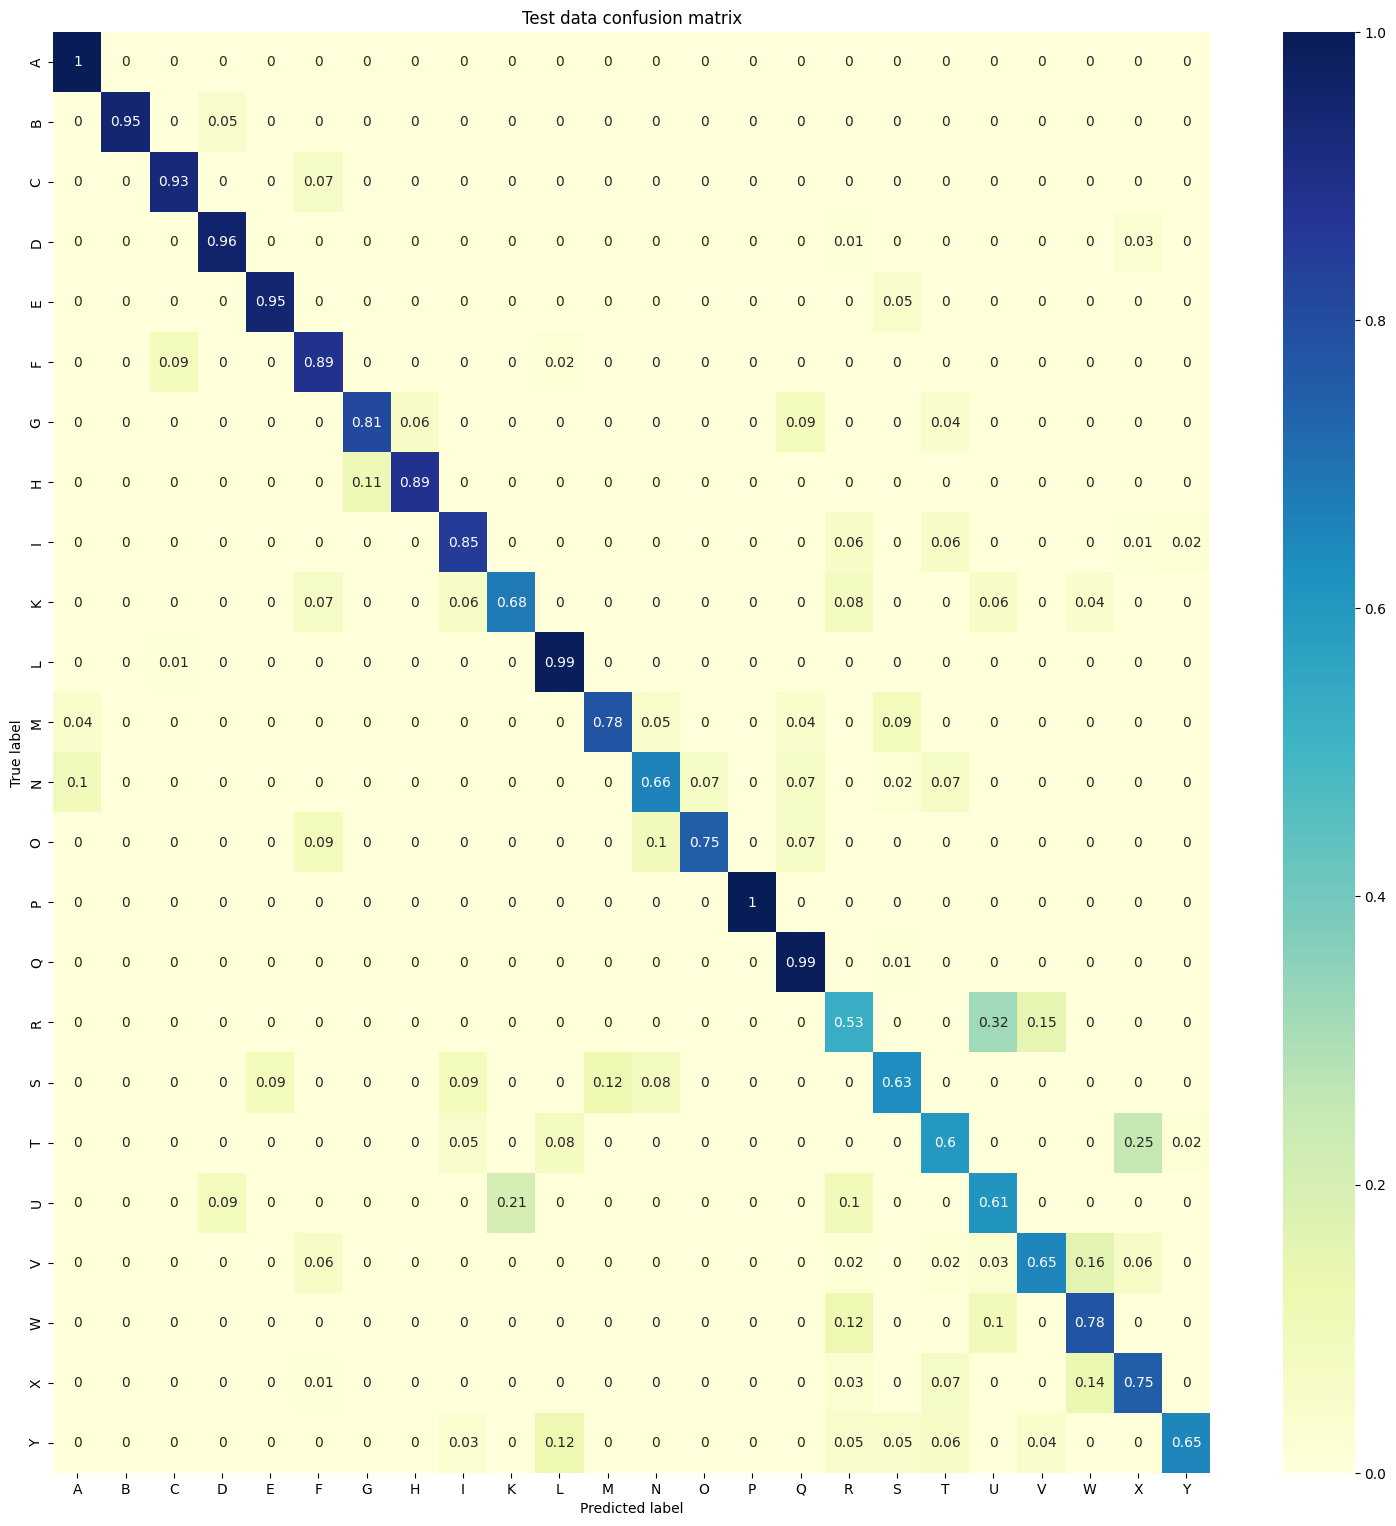

In [16]:
from datetime import datetime

log_dir1 = "./summaries/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print (log_dir1)

tf.reset_default_graph()
net1 = MLP(
    [784,256,25], 
    w_std=0.001, lr=0.001
    ) # Adam is the default optimizer

hist1 = net1.train(
    x_train, y_train_hot, 
    x_valid, y_valid_hot,
    eps=20, bs=1024,
    log_dir = log_dir1
    )
# ============================== Test
y_pred = show_test_results(net1, x_test, y_test)



### B. SGD

./summaries/20221202-234236


C:\Users\MohammadReza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


*** Epoch 5 ***
training loss: 1.12	training accuracy: 67.4%
validation loss: 1.15	validation accuracy: 65.3%

*** Epoch 10 ***
training loss: 0.35	training accuracy: 93.3%
validation loss: 0.38	validation accuracy: 92.3%

*** Epoch 15 ***
training loss: 0.13	training accuracy: 99.3%
validation loss: 0.14	validation accuracy: 99.1%

*** Epoch 20 ***
training loss: 0.06	training accuracy: 100.0%
validation loss: 0.07	validation accuracy: 99.9%

*** Epoch 25 ***
training loss: 0.04	training accuracy: 100.0%
validation loss: 0.04	validation accuracy: 100.0%

*** Epoch 30 ***
training loss: 0.03	training accuracy: 100.0%
validation loss: 0.03	validation accuracy: 100.0%

correct predictions:	5671 out of 7172
test data accuracy:	0.7907138873396542



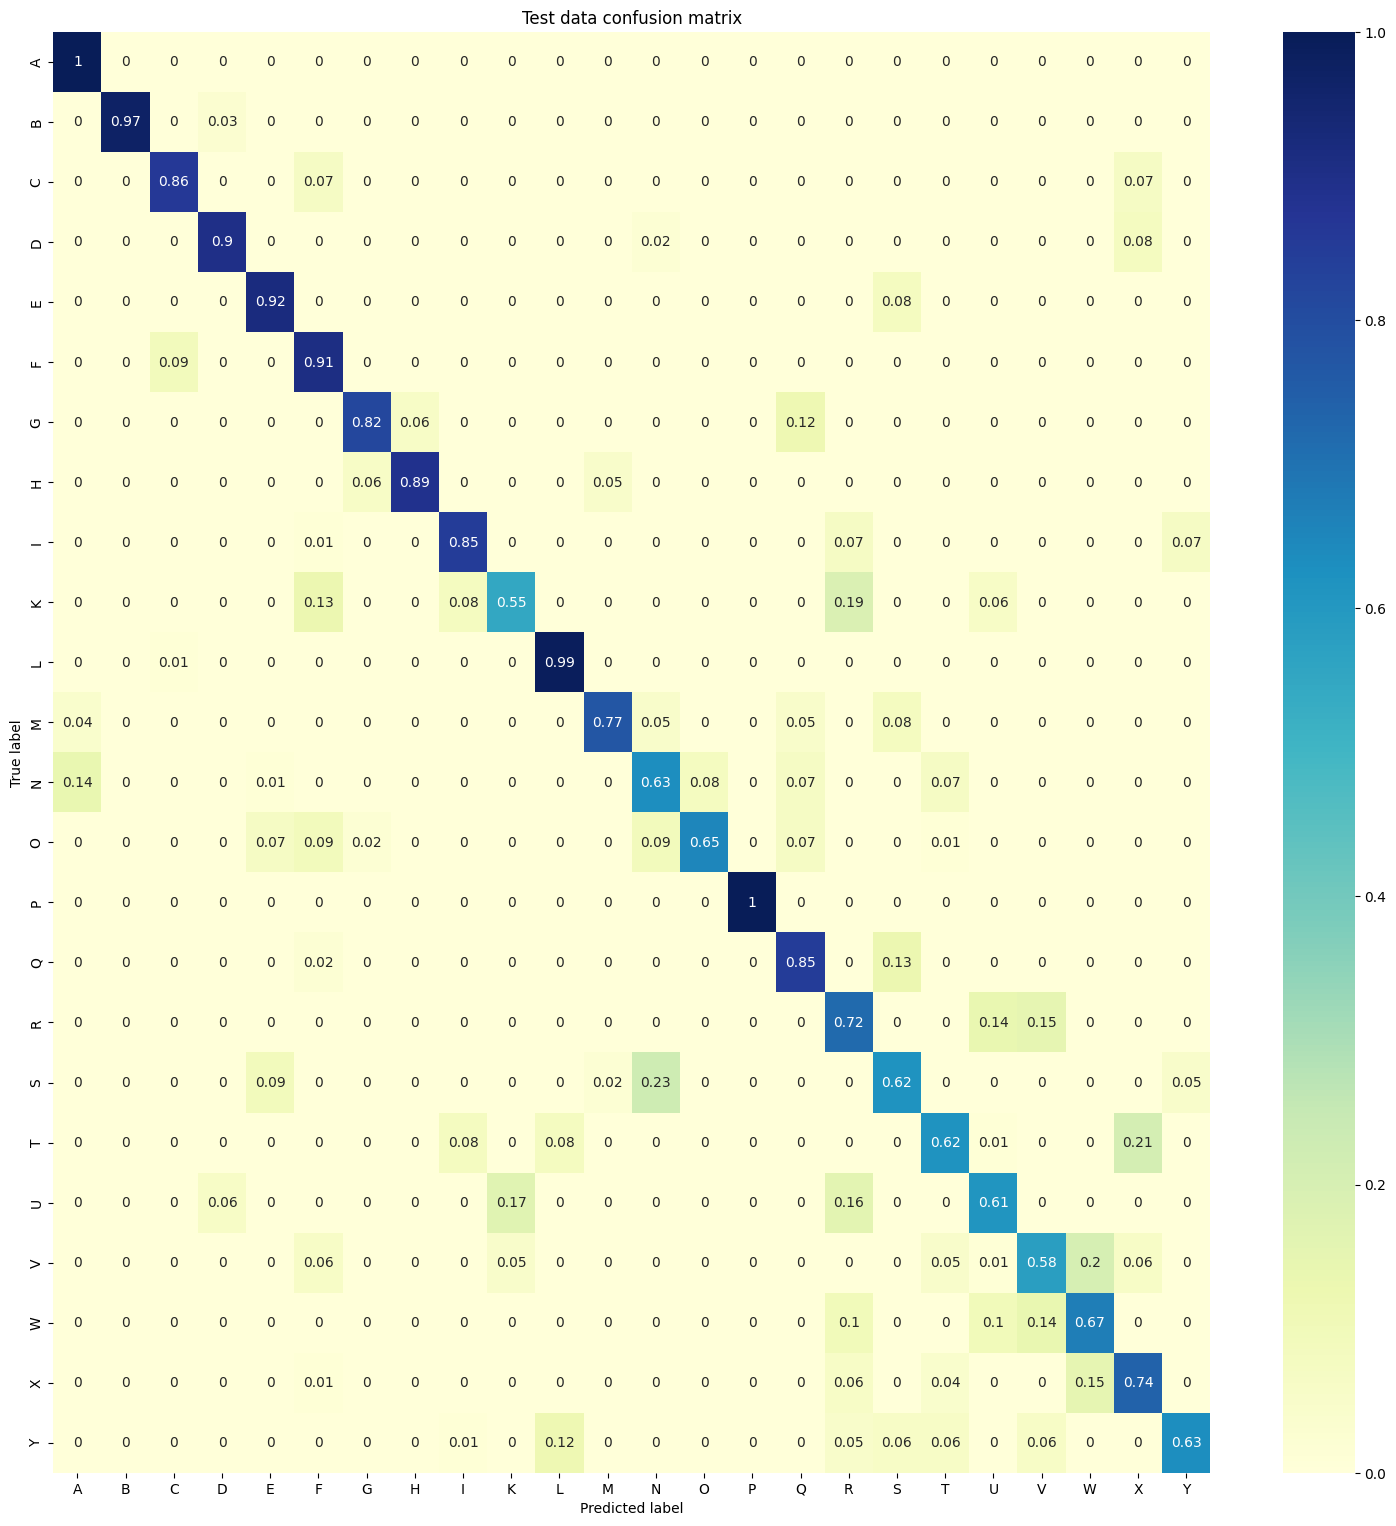

In [17]:
from datetime import datetime

log_dir2 = "./summaries/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print (log_dir2)

tf.reset_default_graph()
net2 = MLP(
    [784,256,25],
    optimizer=tf.train.GradientDescentOptimizer,
    lr=0.05, dropout=0, bn=False, w_std=0.001
)

hist2 = net2.train(
    x_train, y_train_hot, 
    x_valid, y_valid_hot,
    eps=30, bs=256,
    log_dir = log_dir2
    )

# ============================== Test
y_pred = show_test_results(net2, x_test, y_test)




# Question B
The difference between the two algorithms is in the type of learning rate calculation. In SGD, a learning rate is used to train all parameters of the network, but in ADAM, for each parameter of the network, two momentum terms are considered for that parameter, and each parameter is trained with its own moments.

## C. Adam with Dropout

./summaries/20221202-234306


C:\Users\MohammadReza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


*** Epoch 5 ***
training loss: 0.32	training accuracy: 94.1%
validation loss: 0.34	validation accuracy: 93.2%

*** Epoch 10 ***
training loss: 0.05	training accuracy: 100.0%
validation loss: 0.05	validation accuracy: 100.0%

*** Epoch 15 ***
training loss: 0.01	training accuracy: 100.0%
validation loss: 0.01	validation accuracy: 100.0%

*** Epoch 20 ***
training loss: 0.01	training accuracy: 100.0%
validation loss: 0.01	validation accuracy: 100.0%

*** Epoch 25 ***
training loss: 0.00	training accuracy: 100.0%
validation loss: 0.00	validation accuracy: 100.0%

*** Epoch 30 ***
training loss: 0.00	training accuracy: 100.0%
validation loss: 0.00	validation accuracy: 100.0%

correct predictions:	5816 out of 7172
test data accuracy:	0.8109313998884551



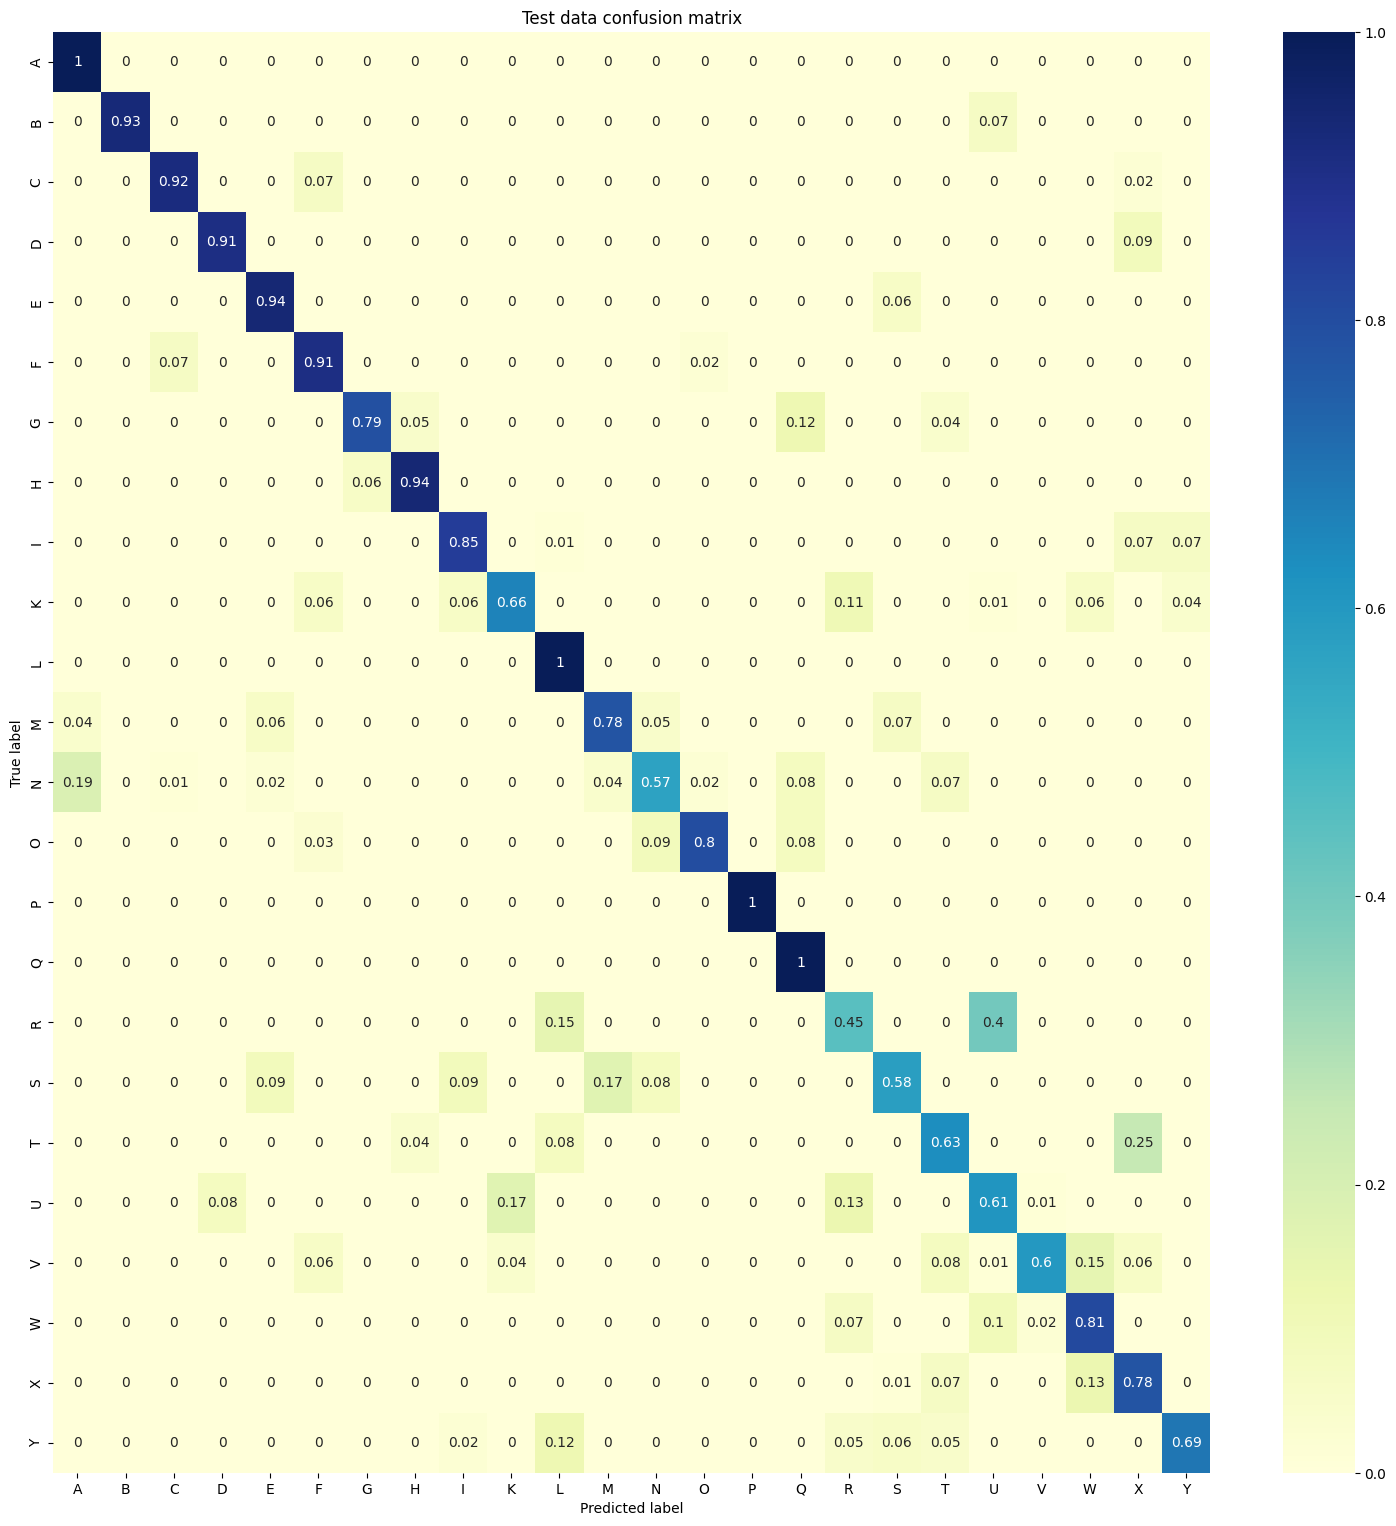

In [18]:
from datetime import datetime

log_dir3 = "./summaries/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print (log_dir3)

tf.reset_default_graph()
net1 = MLP(
    [784,256,25], 
    w_std=0.001, lr=0.001, dropout=0.5
    ) # Adam is the default optimizer

hist1 = net1.train(
    x_train, y_train_hot, 
    x_valid, y_valid_hot,
    eps=30, bs=1024,
    log_dir = log_dir3
    )

# ============================== Test
y_pred = show_test_results(net1, x_test, y_test)

## C. SGD with Dropout

./summaries/20221202-234334


C:\Users\MohammadReza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


*** Epoch 5 ***
training loss: 1.16	training accuracy: 66.6%
validation loss: 1.19	validation accuracy: 64.9%

*** Epoch 10 ***
training loss: 0.42	training accuracy: 91.4%
validation loss: 0.45	validation accuracy: 90.1%

*** Epoch 15 ***
training loss: 0.18	training accuracy: 98.1%
validation loss: 0.20	validation accuracy: 97.7%

*** Epoch 20 ***
training loss: 0.09	training accuracy: 99.8%
validation loss: 0.09	validation accuracy: 99.8%

*** Epoch 25 ***
training loss: 0.05	training accuracy: 100.0%
validation loss: 0.05	validation accuracy: 99.9%

*** Epoch 30 ***
training loss: 0.03	training accuracy: 100.0%
validation loss: 0.03	validation accuracy: 100.0%

correct predictions:	5617 out of 7172
test data accuracy:	0.7831846068042387



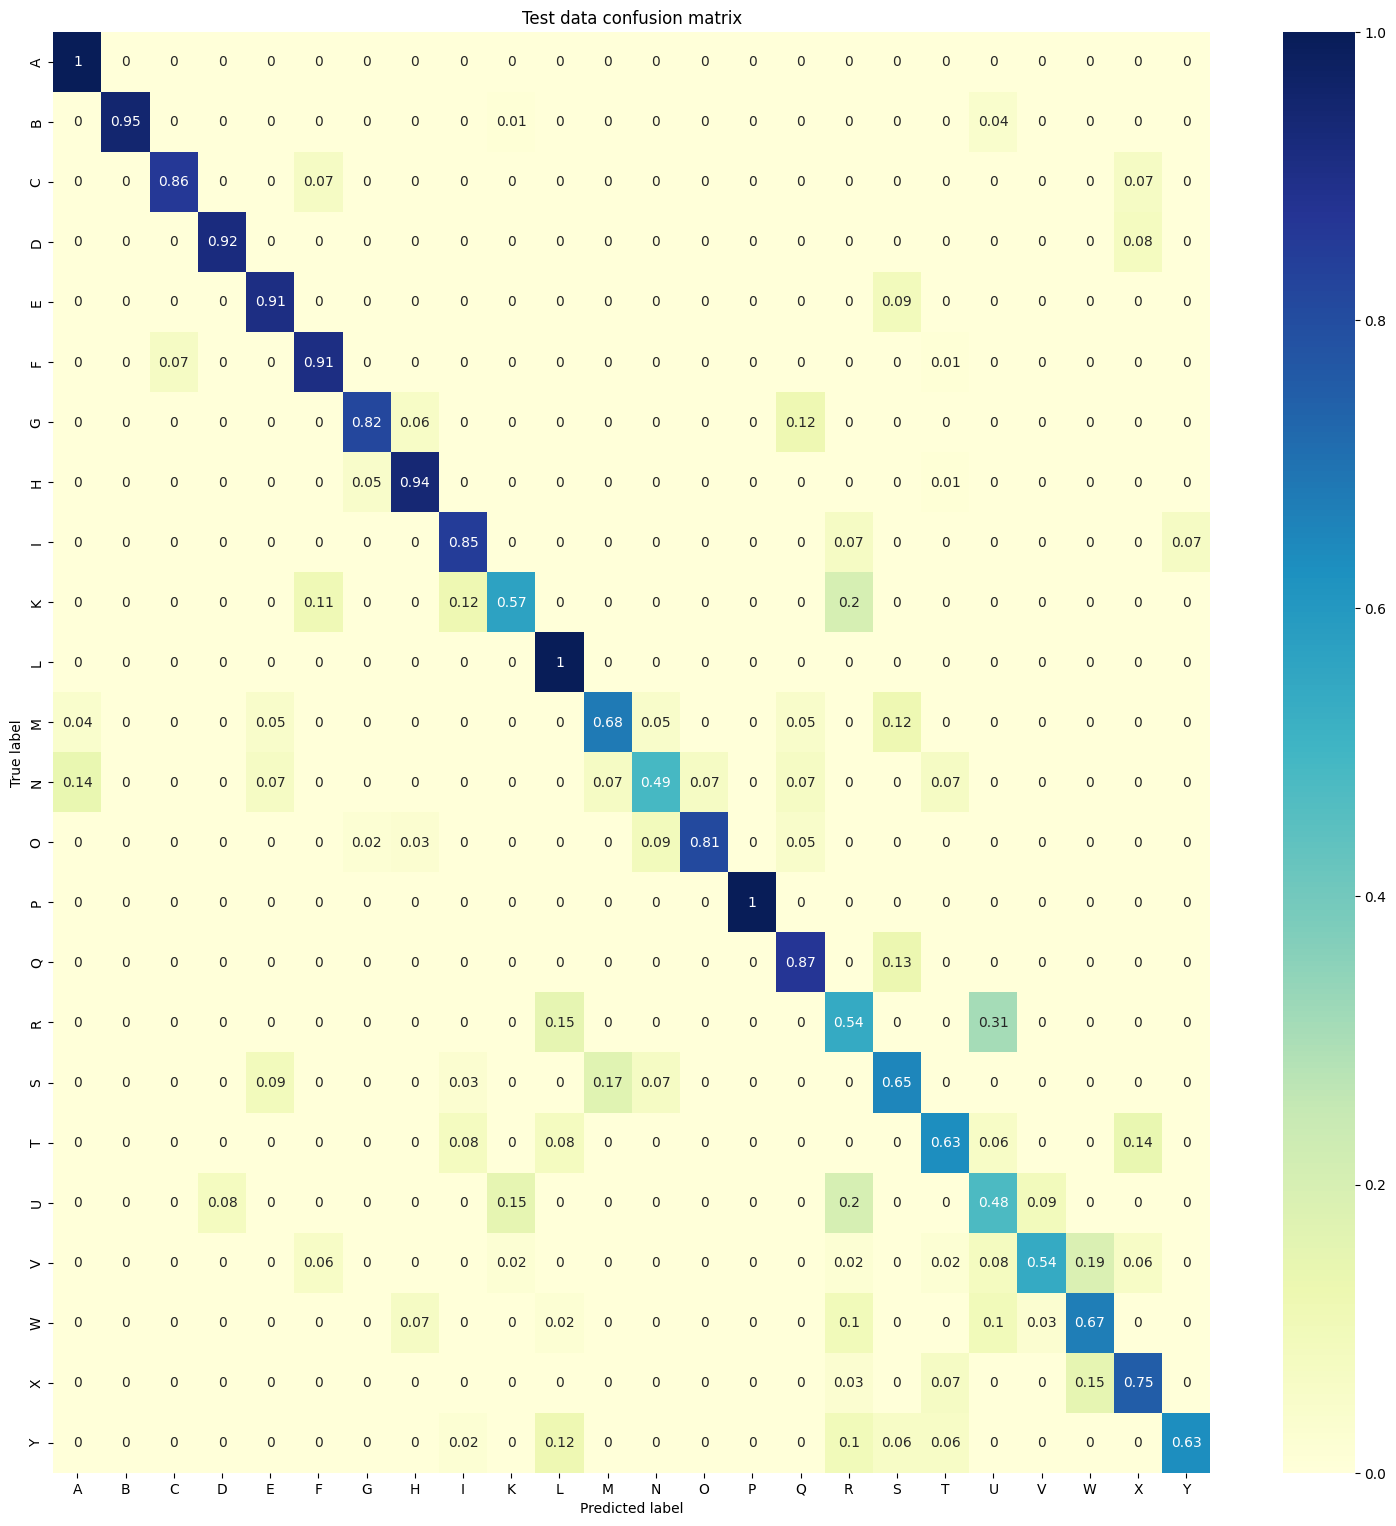

In [19]:
from datetime import datetime

log_dir4 = "./summaries/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print (log_dir4)

tf.reset_default_graph()
net2 = MLP(
    [784,256,25],
    optimizer=tf.train.GradientDescentOptimizer,
    lr=0.05, dropout=0.5, bn=False, w_std=0.001
)

hist2 = net2.train(
    x_train, y_train_hot, 
    x_valid, y_valid_hot,
    eps=30, bs=256,
    log_dir = log_dir4
    )

# ============================== Test
y_pred = show_test_results(net2, x_test, y_test)

# Question B
The difference between the two algorithms is in the type of learning rate calculation. In SGD, a learning rate is used to train all parameters of the network, but in ADAM, for each parameter of the network, two momentum terms are considered for that parameter, and each parameter is trained with its own moments.

# Question C
We keep all the hyperparameters of part B and only add a dropout layer with a rate of 0.5 to the hidden layer.
we do. Again, with the specified number of steps for training, the validation accuracy reaches 100%, but due to
In the presence of dropout, the speed of convergence is lower. Finally, the classification accuracy of the test data with the optimizer
Adam reaches 81.18% and SGD reaches 79.2%.

# Question D
According to previous parts in part B, ADAM had the best accuracy, and the characteristic has been shown in part B.